In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import os
import skimage as ski 
from skimage import io
io.use_plugin('pil')
import PIL
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
def normalize_images(images):
    min_value = np.min(images)
    max_value = np.max(images)
    normalized_images = (images - min_value) / (max_value - min_value)
    return normalized_images

In [3]:
path_name = "//home//rounak//Desktop//KN//"
image_files = [file for file in os.listdir(path_name) if file.endswith(".tiff")]
dataset = []
k=0
for image_file in image_files:
    image_path = os.path.join(path_name,image_file)
    img = io.imread(image_path, plugin='pil')
    dataset.append(normalize_images(np.expand_dims(img[:,:,0], axis=0)))

In [12]:
dataset = []

folder_path = "//home//rounak//Desktop//KN//"
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.tiff'))]
k=0
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    if(k%100==0):
        print(k)
    k+=1
    img_push = np.zeros((323,323,3))
    img = io.imread(image_path, plugin='pil')
    img = np.array(img)
    img_push[:,:,0] = normalize_images(img[:,:,0])
    img_push[:,:,1] = normalize_images(img[:,:,2])
    img_push[:,:,2] = 0.5*normalize_images(img[:,:,0])+0.5*normalize_images(img[:,:,2])
    img_push = np.array(img_push)
    image_array = img_push.T
    tensor = torch.from_numpy(image_array)
    tensor = normalize_images(np.array(tensor))
    tensor = 2*tensor - 1
    dataset.append(tensor)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [13]:
dataset = np.float32(np.array(dataset))

In [14]:
dataset_1 = []
for i in range(5067):
    dataset_1.append(torch.Tensor(dataset[i][:, :320, :320]))
dataset_1 = np.array(dataset_1)

/tmp/ipykernel_6374/1305002630.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  dataset_1 = np.array(dataset_1)
/tmp/ipykernel_6374/1305002630.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset_1 = np.array(dataset_1)


In [17]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device="cuda:1"):
        super(DownBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, flag = 1, device="cuda:1"):
        super(UpBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        if(flag == 1):
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                nn.ReLU(),
                nn.ConvTranspose2d(out_channels, out_channels, 2, 2),
            )
        else:
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                nn.ReLU()
            )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    
class AutoEncoder(nn.Module):
    def __init__(self, in_channels_):
        super(AutoEncoder, self).__init__()
        self.in_channels_ = in_channels_
        layers_1 = [
            DownBlock(in_channels=in_channels_, out_channels=16),
            DownBlock(16, 8),
        ]
        layers_2 = [
            UpBlock(in_channels = 8, out_channels = 16),
            UpBlock(in_channels = 16, out_channels = 16),
            UpBlock(16, in_channels_, 2)
        ]
        layers = [*layers_1, *layers_2]
        self.model = nn.Sequential(*layers)
        self.model_decode = nn.Sequential(*layers_1)
        self.model_encode = nn.Sequential(*layers_2)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    def decode(self, x:torch.Tensor) -> torch.Tensor:
        return self.model_decode(x)
    def encode(self, x:torch.Tensor) -> torch.Tensor:
        return self.model_encode(x)
    
    
auto_encoder = AutoEncoder(3).to("cuda:1")
dataloader = DataLoader(dataset_1, batch_size=128, shuffle=True)
optim = torch.optim.Adam(auto_encoder.parameters(), lr=1e-4)


In [18]:
import os
auto_encoder.train()
loss_lst=[]
loss_val = 0
for ep in range(0, 100):
    print("epoch number: ", ep)
    optim.param_groups[0]['lr'] = 1e-3
    pbar = tqdm(dataloader, mininterval = 2)
    loss_val = 0
    for x in pbar:
        optim.zero_grad()
        x=x.to("cuda:1")
        pred_x = auto_encoder(x)
        loss = F.mse_loss(pred_x, x)
        loss_val += loss
        loss.backward()
        optim.step()
    loss_lst.append(loss_val)



epoch number:  0


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.52it/s]


epoch number:  1


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.77it/s]


epoch number:  2


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.69it/s]


epoch number:  3


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.73it/s]


epoch number:  4


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.71it/s]


epoch number:  5


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.71it/s]


epoch number:  6


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.74it/s]


epoch number:  7


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.69it/s]


epoch number:  8


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  9


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.67it/s]


epoch number:  10


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.67it/s]


epoch number:  11


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.67it/s]


epoch number:  12


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  13


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  14


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  15


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  16


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  17


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.52it/s]


epoch number:  18


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  8.69it/s]


epoch number:  19


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.13it/s]


epoch number:  20


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.68it/s]


epoch number:  21


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.69it/s]


epoch number:  22


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.69it/s]


epoch number:  23


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  24


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


epoch number:  25


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  26


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  27


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  28


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.67it/s]


epoch number:  29


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  30


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  31


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.68it/s]


epoch number:  32


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  33


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


epoch number:  34


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


epoch number:  35


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  36


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


epoch number:  37


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  38


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  39


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  40


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  41


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


epoch number:  42


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  43


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.53it/s]


epoch number:  44


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


epoch number:  45


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  46


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  47


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


epoch number:  48


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  49


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.67it/s]


epoch number:  50


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.67it/s]


epoch number:  51


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.68it/s]


epoch number:  52


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  53


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  54


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.67it/s]


epoch number:  55


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  56


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  57


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  58


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.55it/s]


epoch number:  59


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


epoch number:  60


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  61


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  62


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  63


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  64


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


epoch number:  65


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  66


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  67


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  68


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  69


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


epoch number:  70


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  71


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  72


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  73


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  74


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.67it/s]


epoch number:  75


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  76


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  77


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  78


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


epoch number:  79


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  80


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  81


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  82


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  83


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  84


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


epoch number:  85


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


epoch number:  86


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


epoch number:  87


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


epoch number:  88


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  89


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


epoch number:  90


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  91


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  92


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  93


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  94


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.44it/s]


epoch number:  95


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  96


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


epoch number:  97


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


epoch number:  98


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


epoch number:  99


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


In [8]:
loss_lst

[tensor(1723.4388, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.2413, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.4600, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.0488, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.5715, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.2419, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.1556, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.2944, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.1320, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.3461, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.2750, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.2668, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.4703, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.2123, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.1345, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.7494, device='cuda:1', grad_fn=<AddBackward0>),
 tensor(1723.5640, devic

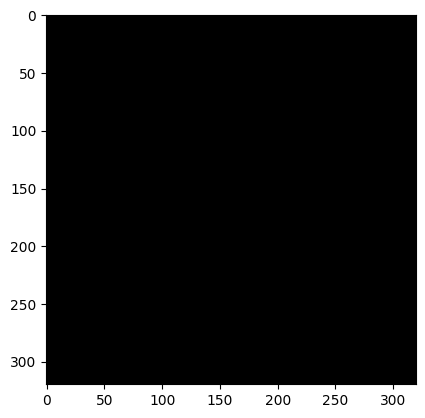

In [19]:
x = auto_encoder(torch.Tensor(dataset_1[2]).to("cuda:1"))
x = x.cpu().data.numpy()
plt.imshow(x.T, cmap="gray")

TypeError: Invalid shape (1, 320, 320) for image data

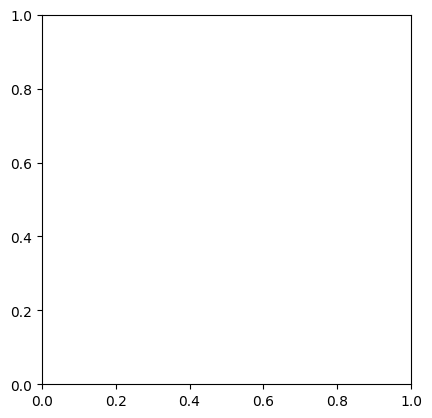

In [10]:
y = ski.morphology.skeletonize(x)
plt.imshow(y.T, cmap="gray")

In [ ]:
dataset_skeleton = []
for i in range(5067):
    x = auto_encoder(torch.Tensor(dataset_1[i]).to("cuda:1"))
    x = x.cpu().data.numpy()
    dataset_skeleton.append(ski.morphology.skeletonize(np.array(x)))
dataset_skeleton = np.array(dataset_skeleton)

In [ ]:
def line_finder(image, height):
    dx = [1,1,1,-1,-1,-1,0,0]
    dy = [0,1,-1,0,1,-1,1,-1]
    data = []
    p=0
    for i in range(0, height):
        for j in range(0, height):
            x = image[i][j]
            data.append((i,j))
            while(x!=0):
                p=1
                for k in range(8):
                    if(image[i+dx[k]][j+dy[k]] == 1):
                        x = image[i+dx[k]][j+dy[k]]
                        data.append((i+dx[k], j+dy[k]))
            if(p==1):
                break
                        
    return data

In [ ]:
points = line_finder(dataset_skeleton[0], 320)
points